In [1]:
import pickle
import scipy
from hashlib import sha256
from pathlib import Path
from typing import Sequence

import numpy as np
from matplotlib import pyplot as plt

from src.functions.__const__ import HASH_LENGTH
from src.plot_scripts.common import get_parameters
from z_outputs.plots import get_plots_path
from z_outputs.results import get_results_path
from z_outputs.cache import get_cache_path

In [2]:
slurm_id = 2040737
basepath = get_results_path()
get_cache_path = lambda: Path(rf"/scratch/slurm-{slurm_id}/cache")

In [3]:
location = basepath / "simulation_3_868d1548_11110.sqlite"

In [4]:
location = Path(location)
is_reciprocal = location.stem.split("_")[2][1] != "0"
parameters = {
    "coupling": "properties|::Root Element::R_1|coupling",
    "phase": "properties|::Root Element::R_1|phase",
    "t_1": "results|::Root Element::OSA_R_1_rt|mode 1/signal|values",
    "t_2": f"results|::Root Element::OSA_R_1_{'lb' if is_reciprocal else 'rb'}|mode 1/signal|values",
    "f_1": "results|::Root Element::OSA_R_1_rt|mode 1/signal|Frequency",
    "f_2": f"results|::Root Element::OSA_R_1_{'lb' if is_reciprocal else 'rb'}|mode 1/signal|Frequency",
}

In [5]:
parameters = get_parameters(location, parameters, False)

Loaded 'properties|::Root Element::R_1|coupling' from 'simulation_11110_868d1548_9efcf18d.pkl'
Loaded 'properties|::Root Element::R_1|phase' from 'simulation_11110_868d1548_cb588602.pkl'
Loaded 'results|::Root Element::OSA_R_1_rt|mode 1/signal|values' from 'simulation_11110_868d1548_70701269.pkl'
Loaded 'results|::Root Element::OSA_R_1_lb|mode 1/signal|values' from 'simulation_11110_868d1548_474d3cca.pkl'
Loaded 'results|::Root Element::OSA_R_1_rt|mode 1/signal|Frequency' from 'simulation_11110_868d1548_eebcd579.pkl'
Loaded 'results|::Root Element::OSA_R_1_lb|mode 1/signal|Frequency' from 'simulation_11110_868d1548_d40bbbd3.pkl'


In [6]:
phi_shift = np.pi if is_reciprocal else (np.pi / 2)
phi_limits = (0, np.pi) if is_reciprocal else (-np.pi / 2, np.pi / 2)

all_phases = np.unique(parameters["phase"])
using_phi_shift = all_phases[np.argmin(np.abs(all_phases - phi_shift))]
print("Using phase shift:", using_phi_shift)
coupling = 0.5
all_coupling = np.unique(parameters["coupling"])
using_coupling = all_coupling[np.argmin(np.abs(all_coupling - coupling))]
print("Using coupling:", using_coupling)
coupling_phi_index = np.where((parameters["coupling"] == using_coupling) & (parameters["phase"] == using_phi_shift))[0][0]
print("Using coupling_phi_index:", coupling_phi_index)

Using phase shift: 3.091726103533
Using coupling: 0.507936507937
Using coupling_phi_index: 3040


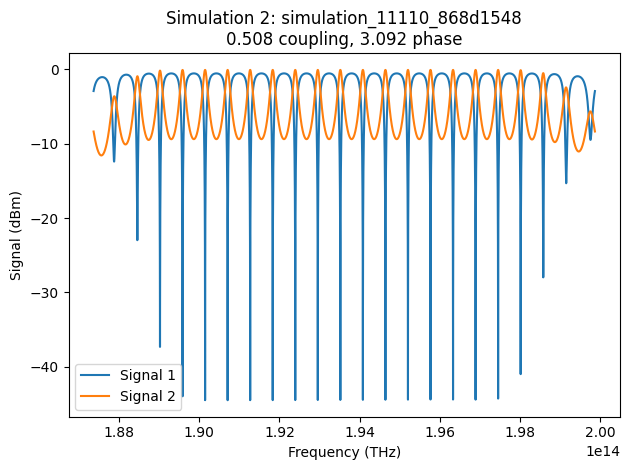

In [7]:
fig, ax = plt.subplots(1, 1)
ax.plot(parameters["f_1"][coupling_phi_index], parameters["t_1"][coupling_phi_index], label="Signal 1")
ax.plot(parameters["f_2"][coupling_phi_index], parameters["t_2"][coupling_phi_index], label="Signal 2")
ax.set_xlabel("Frequency (THz)")
ax.set_ylabel("Signal (dBm)")
ax.set_title(f"Simulation 2: {location.stem}\n{parameters['coupling'][coupling_phi_index]:.3f} coupling, {parameters['phase'][coupling_phi_index]:.3f} phase")
ax.legend()
plt.tight_layout()
plt.show()
plt.close(fig)

In [8]:
frequency = 3e8 / 1550e-9
signal_1_on_index = np.array(parameters["t_1"][coupling_phi_index])
freq_on_index = np.array(parameters["f_1"][coupling_phi_index])
peaks = np.where(signal_1_on_index < (np.min(signal_1_on_index) * 0.9))[0]
freq_of_peaks = freq_on_index[peaks]
using_freq = freq_of_peaks[np.argmin(np.abs(freq_of_peaks - frequency))]
freq_index = peaks[np.argmin(np.abs(freq_of_peaks - frequency))]

print(f"Using frequency (probe at): {3e8 * 1e9 / using_freq:.3f} nm or {using_freq * 1e-12:.3f} THz")
print(f"Using index: {freq_index}")

Using frequency (probe at): 1550.239 nm or 193.519 THz
Using index: 49220


In [9]:
freq_1545 = np.argmin(np.abs(freq_on_index - 3e8 / 1545e-9))
freq_1555 = np.argmin(np.abs(freq_on_index - 3e8 / 1555e-9))
new_freq = freq_on_index[freq_1555:freq_1545]

new_parameters = {
    "coupling": parameters["coupling"],
    "phase": parameters["phase"],
    "signal_1": [],
    "signal_2": [],
    "frequencies": new_freq,
}

for i in range(len(parameters["coupling"])):
    if isinstance(parameters["t_1"][i], Sequence):
        new_parameters["signal_1"].append(parameters["t_1"][i][freq_1555:freq_1545])
    else:
        new_parameters["signal_1"].append([parameters["t_1"][i]] * len(new_freq))
    if isinstance(parameters["t_2"][i], Sequence):
        new_parameters["signal_2"].append(parameters["t_2"][i][freq_1555:freq_1545])
    else:
        new_parameters["signal_2"].append([parameters["t_2"][i]] * len(new_freq))

new_parameters["signal_1"] = np.array(new_parameters["signal_1"])
new_parameters["signal_2"] = np.array(new_parameters["signal_2"])


In [10]:
coupling_08_10 = np.where((new_parameters['coupling'] >= 0.8) & (new_parameters['coupling'] <= 1) & (new_parameters["phase"] >= phi_limits[0]) & (new_parameters["phase"] <= phi_limits[1]))
new_parameters_08_10 = {
    "coupling": new_parameters['coupling'][coupling_08_10],
    "phase": new_parameters["phase"][coupling_08_10],
    "signal_1": new_parameters["signal_1"][coupling_08_10],
    "signal_2": new_parameters["signal_2"][coupling_08_10],
    "frequencies": new_parameters["frequencies"],
}
coupling_00_02 = np.where((new_parameters['coupling'] >= 0) & (new_parameters['coupling'] <= 0.2) & (new_parameters["phase"] >= phi_limits[0]) & (new_parameters["phase"] <= phi_limits[1]))
new_parameters_00_02 = {
    "coupling": new_parameters['coupling'][coupling_00_02],
    "phase": new_parameters["phase"][coupling_00_02],
    "signal_1": new_parameters["signal_1"][coupling_00_02],
    "signal_2": new_parameters["signal_2"][coupling_00_02],
    "frequencies": new_parameters["frequencies"],
}
scipy.io.savemat("simulation_" + ("reciprocal" if is_reciprocal else "non_reciprocal") + "_08_10.mat", new_parameters_08_10)
scipy.io.savemat("simulation_" + ("reciprocal" if is_reciprocal else "non_reciprocal") + "_00_02.mat", new_parameters_00_02)

In [11]:
er_p = np.array([np.nan] * len(parameters["coupling"]))

for i in range(len(parameters["coupling"])):
    if not isinstance(parameters["t_1"][i], Sequence):
        continue
    if not isinstance(parameters["t_2"][i], Sequence):
        continue
    er_p[i] = parameters["t_1"][i][freq_index] - parameters["t_2"][i][freq_index]


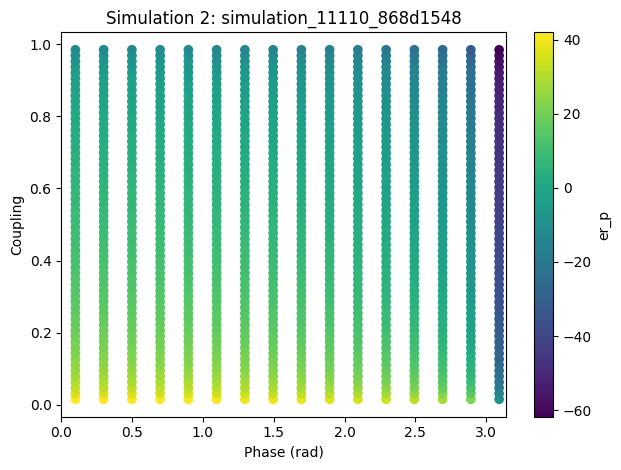

In [12]:
fig, ax = plt.subplots(1, 1)
sc = ax.scatter(parameters["phase"], parameters["coupling"], c=er_p)
cbar = plt.colorbar(sc)
cbar.set_label("er_p")
ax.set_xlabel("Phase (rad)")
ax.set_ylabel("Coupling")
ax.set_title(f"Simulation 2: {location.stem}")
ax.set_xlim(*phi_limits)
plt.tight_layout()
plt.show()

In [13]:
print(np.unique(parameters["coupling"]))

[0.         0.01587302 0.03174603 0.04761905 0.06349206 0.07936508
 0.0952381  0.11111111 0.12698413 0.14285714 0.15873016 0.17460317
 0.19047619 0.20634921 0.22222222 0.23809524 0.25396825 0.26984127
 0.28571429 0.3015873  0.31746032 0.33333333 0.34920635 0.36507937
 0.38095238 0.3968254  0.41269841 0.42857143 0.44444444 0.46031746
 0.47619048 0.49206349 0.50793651 0.52380952 0.53968254 0.55555556
 0.57142857 0.58730159 0.6031746  0.61904762 0.63492063 0.65079365
 0.66666667 0.68253968 0.6984127  0.71428571 0.73015873 0.74603175
 0.76190476 0.77777778 0.79365079 0.80952381 0.82539683 0.84126984
 0.85714286 0.87301587 0.88888889 0.9047619  0.92063492 0.93650794
 0.95238095 0.96825397 0.98412698 1.        ]


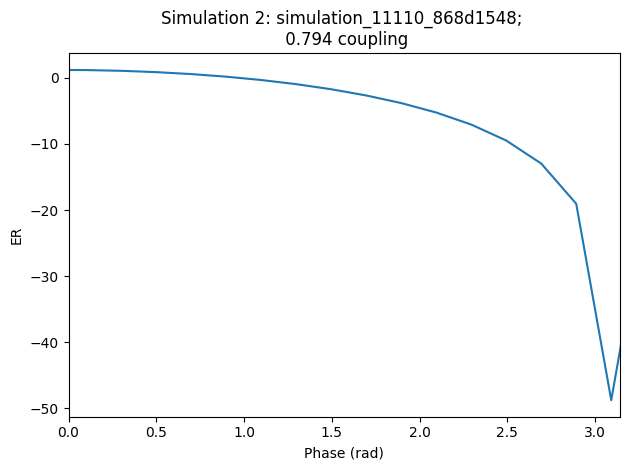

In [14]:
fig, ax = plt.subplots(1, 1)
with_coupling = all_coupling[np.argmin(np.abs(all_coupling - 0.8))]
indexes = parameters["coupling"] == with_coupling
sc = ax.plot(parameters["phase"][indexes], er_p[indexes])
ax.set_xlabel("Phase (rad)")
ax.set_ylabel("ER")
ax.set_title(f"Simulation 2: {location.stem}; \n {with_coupling:.3f} coupling")
ax.set_xlim(*phi_limits)
plt.tight_layout()
plt.show()